### Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from scipy import stats

# Load the dataset
df = pd.read_csv('data/house_price.csv')

# Bỏ cột Id
cols_to_drop = ['Id']
df = df.drop(cols_to_drop, axis=1)

# Define function to check missing values
def check_nan_df(df):
    miss = df.isna().sum()
    miss = miss[miss > 0]
    print('Danh sách các cột thiếu dữ liệu:\n')
    print(miss)
    print('\n\nSố lượng cột có dữ liệu thiếu:', len(miss))
    return miss

# Check missing values
miss = check_nan_df(df)

# Drop columns with more than half missing values
cols_to_drop = list(miss[miss > len(df)//2].index)
df.drop(columns=cols_to_drop, inplace=True)

# Check missing values again
miss = check_nan_df(df)

# Handle missing values in specific columns
bsmt_list = [col for col in miss.index if 'Bsmt' in col]
for bsmt_type in bsmt_list:
    if df[bsmt_type].dtypes == 'object':
        df[bsmt_type] = df[bsmt_type].fillna('NA')
    else:
        df[bsmt_type] = df[bsmt_type].fillna(0)

garage_list = [col for col in miss.index if 'Garage' in col]
for garage_type in garage_list:
    if df[garage_type].dtypes == 'object':
        df[garage_type] = df[garage_type].fillna('NA')
    else:
        df[garage_type] = df[garage_type].fillna(0)

# Fill missing values with median for 'LotFrontage' and 'MasVnrArea'
df['LotFrontage'] = df['LotFrontage'].fillna(np.nanmedian(df['LotFrontage']))
df['MasVnrArea'] = df['MasVnrArea'].fillna(np.nanmedian(df['MasVnrArea']))

# Drop rows with missing values in 'Electrical'
print(f'len dataframe before drop: {len(df)}')
df = df.dropna(subset=['Electrical'])
print(f'len dataframe after drop {len(df)}')

# Fill missing values in 'FireplaceQu' with 'NA'
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')


Danh sách các cột thiếu dữ liệu:

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Số lượng cột có dữ liệu thiếu: 19
Danh sách các cột thiếu dữ liệu:

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


Số lượng cột có dữ liệu thiếu: 14
len dataframe before drop: 1460
len dataframe after drop 1459


### Ordinal Encoding

In [2]:
# Create a copy of the dataframe
df_simple = df.copy()

# Encode ordinal data columns
cols_to_encode = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                  'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

# Apply OrdinalEncoder to categorical columns
ordinal_encoder = OrdinalEncoder()
df_simple[cols_to_encode] = ordinal_encoder.fit_transform(df_simple[cols_to_encode])


other_cat_cols = list(df.select_dtypes(include=['object']).columns)

# Apply LabelEncoder to other categorical columns
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to other categorical columns
for col in other_cat_cols:
    df_simple[col] = label_encoder.fit_transform(df_simple[col])

### Create a function for all training models

In [3]:
# Define function to train model
def train_model(X, y, model):
    '''
    Args:
        x: input
        y: groundtruth
        model: model instance (sklearn model)
    Return:
        model: trained model sau khi gọi hàm fit
        score: training score
    '''
    # Print the model name
    print("Model:", model)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)
    
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print("Training set score: {:.4f}".format(train_score))
    
    # Evaluate model performance on testing data
    test_score = model.score(X_test, y_test)
    print("Testing set score (test_size=0.3): {:.4f}".format(test_score))
    
    # Predict y values on X test
    y_pred = model.predict(X_test)
    # Plot outputs
    pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).plot.scatter(x='True Values', y='Predicted Values', title = "{}".format(model))

    return model, train_score, test_score

## 1/ Perform ordinal-encoding based on sklearn's library on the ordinal data column and retrain the Linear regression model.

Model: LinearRegression()
Training set score: 0.8759
Testing set score (test_size=0.3): 0.7143


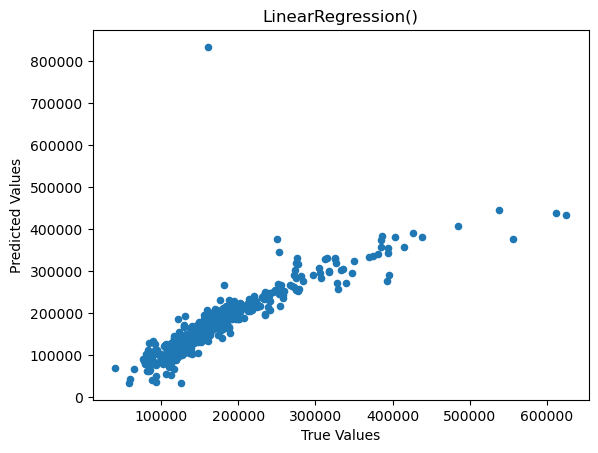

In [4]:
# Define features (X) and target variable (y)
X = df_simple.drop('SalePrice', axis=1)
y = df_simple['SalePrice']
# Initialize Linear Regression model
lr = LinearRegression()
# Train Linear Regression model with the transformed data
lr_transformed, lr_train_score_transformed, lr_test_score_transformed = train_model(X, y, lr)

## 2/ Perform one-hot encoding for the entire price data set and retrain the ridge and lasso model with appropriate parameters.

Model: Ridge(alpha=100, max_iter=10000)
Training set score: 0.8839
Testing set score (test_size=0.3): 0.7238
Model: Ridge(alpha=10, max_iter=10000)
Training set score: 0.9177
Testing set score (test_size=0.3): 0.7478
Model: Ridge(alpha=1, max_iter=10000)
Training set score: 0.9366
Testing set score (test_size=0.3): 0.7234
Model: Ridge(alpha=0.1, max_iter=10000)
Training set score: 0.9441
Testing set score (test_size=0.3): 0.6756
Model: Ridge(alpha=0.01, max_iter=10000)
Training set score: 0.9449
Testing set score (test_size=0.3): 0.6591
Model: Ridge(alpha=0.001, max_iter=10000)
Training set score: 0.9449
Testing set score (test_size=0.3): 0.6566


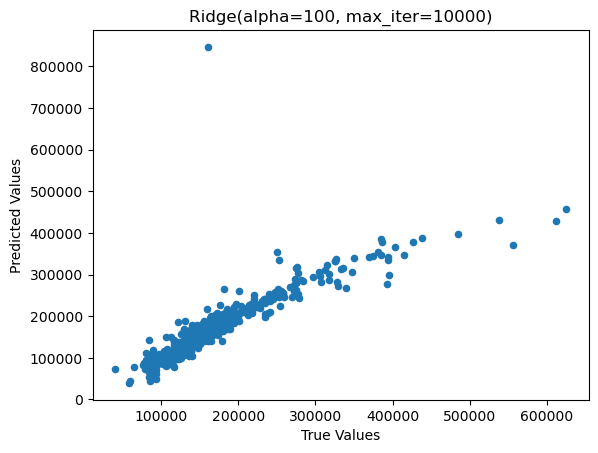

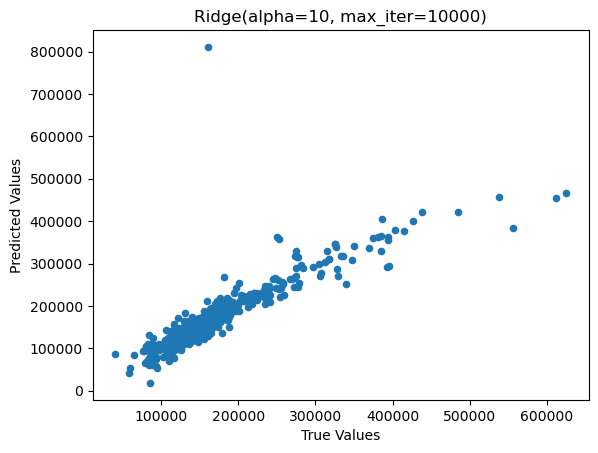

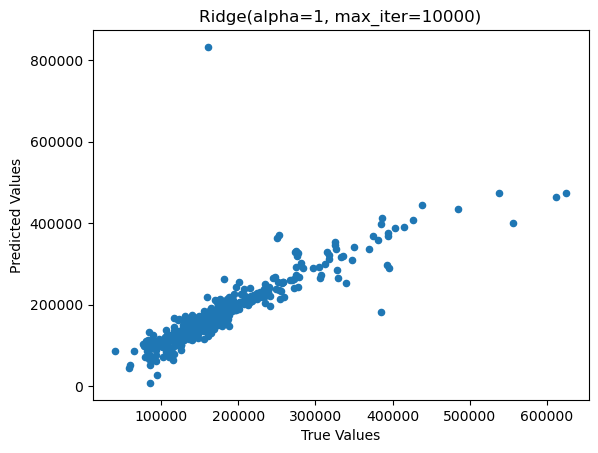

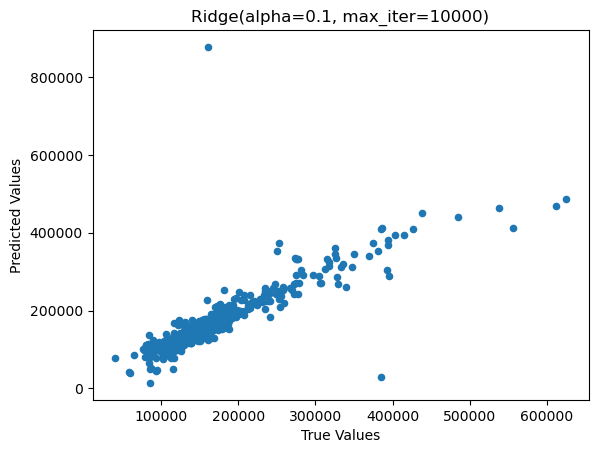

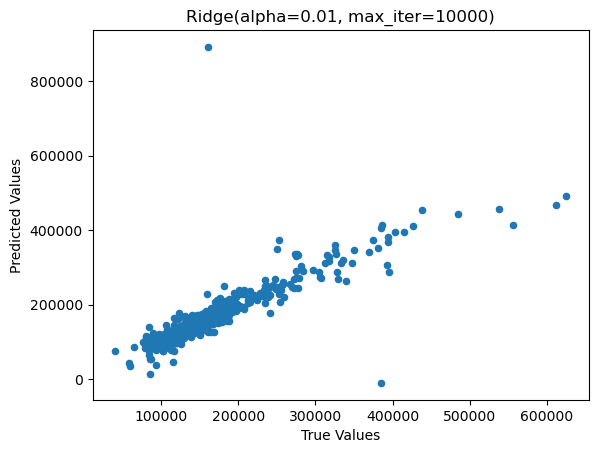

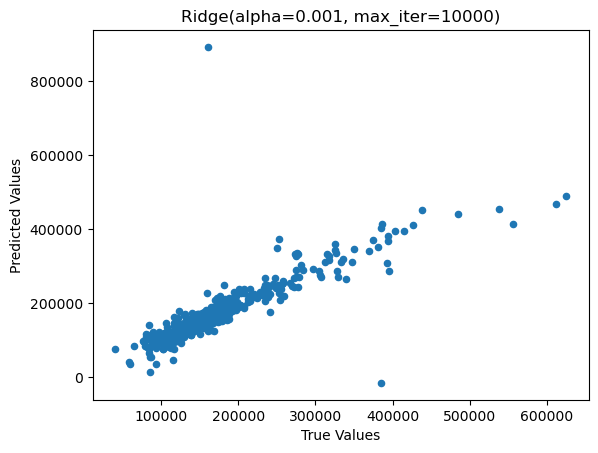

In [5]:
# Perform one-hot encoding for the entire dataset
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features (X_encoded) and target variable (y_encoded) after encoding
X_encoded = df_encoded.drop('SalePrice', axis=1)
y_encoded = df_encoded['SalePrice']

alphas = [100, 10, 1, 0.1, 0.01, 0.001]
for alpha in alphas:
    # Initialize Ridge model
    ridge = Ridge(alpha=alpha, max_iter=10000)

    # Train Ridge model
    ridge, ridge_train_score, ridge_test_score = train_model(X_encoded, y_encoded, ridge)


Model: Lasso(alpha=100, max_iter=100000)
Training set score: 0.9306
Testing set score (test_size=0.3): 0.7199
Model: Lasso(alpha=10, max_iter=100000)
Training set score: 0.9426
Testing set score (test_size=0.3): 0.6739
Model: Lasso(alpha=1, max_iter=100000)
Training set score: 0.9448
Testing set score (test_size=0.3): 0.6637
Model: Lasso(alpha=0.1, max_iter=100000)
Training set score: 0.9449
Testing set score (test_size=0.3): 0.6610
Model: Lasso(alpha=0.01, max_iter=100000)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e+10, tolerance: 6.331e+08
  model = cd_fast.enet_coordinate_descent(


Training set score: 0.9449
Testing set score (test_size=0.3): 0.6607
Model: Lasso(alpha=0.001, max_iter=100000)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.293e+10, tolerance: 6.331e+08
  model = cd_fast.enet_coordinate_descent(


Training set score: 0.9449
Testing set score (test_size=0.3): 0.6598


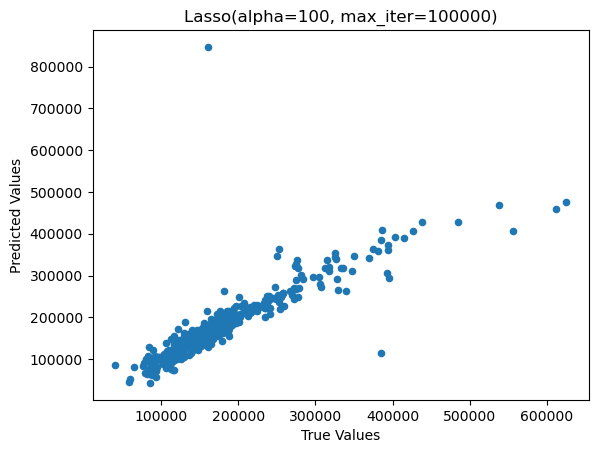

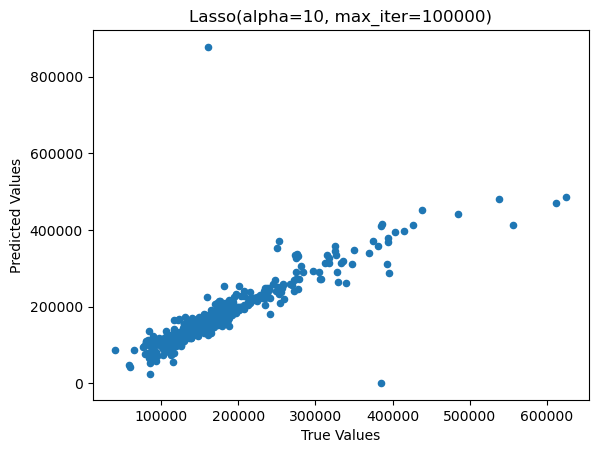

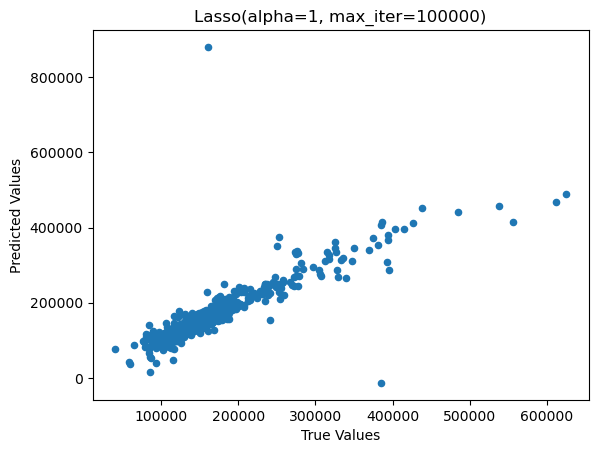

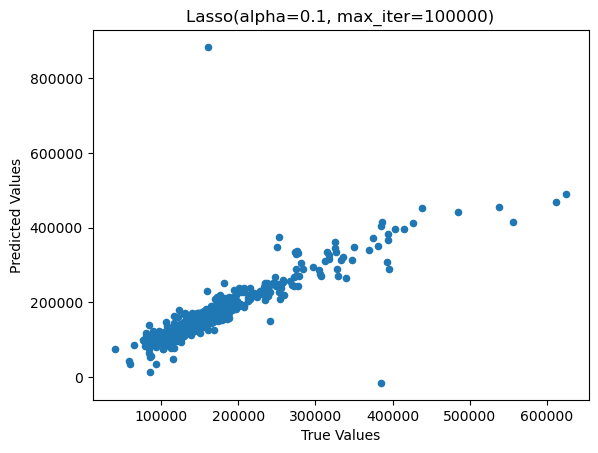

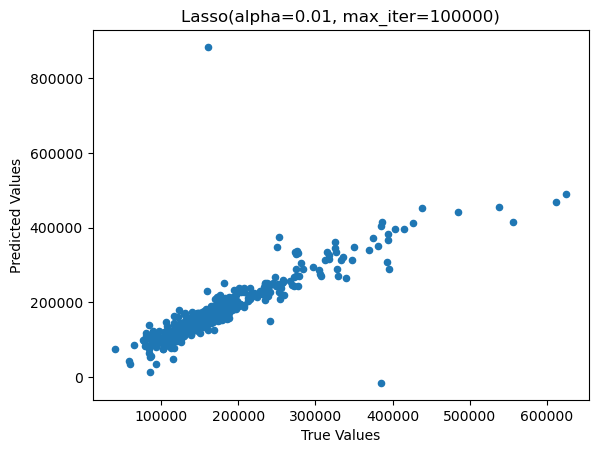

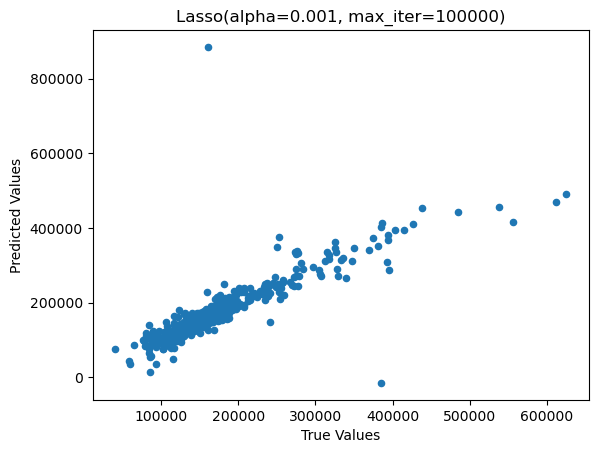

In [6]:
for alpha in alphas:
    # Initialize Lasso model
    lasso = Lasso(alpha=alpha, max_iter=100000)

    # Train Lasso model
    lasso, lasso_train_score, lasso_test_score = train_model(X_encoded, y_encoded, lasso)

## 3/ Check to see if other data fields are still noisy, filter the noise and retrain the elastic net model

In [7]:
numeric_feats = df_simple.dtypes[df_simple.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_simple[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
Utilities,38.157577
MiscVal,24.443278
PoolArea,14.807992
Condition2,13.153749
LotArea,12.190881
...,...
GarageCond,-3.578555
SaleType,-3.863106
GarageYrBlt,-3.863962
Functional,-4.079122


In [8]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if abs(skewness.loc[feat]['Skew']) > 0.75:
        df_simple[feat] = boxcox1p(df_simple[feat], lam)

# Check the skewness of the transformed data
skewness = skew(df_simple[skewed_features])

print(f'Skewness: {skewness}')

Skewness: [ 3.81575770e+01  5.50346191e+00  1.43584269e+01  2.67656119e+00
  7.51906248e-01  7.82501455e+00  8.05626218e+00  7.59056640e+00
  7.64053296e+00  4.34414015e+00  3.99413365e+00  2.61809246e+00
  3.18303639e+00  3.94208395e+00  2.15980308e+00 -4.10210662e-01
  6.03135250e-01 -5.22487160e-01  1.14914700e-01  2.04839481e+00
  3.67885355e-01 -4.98340288e-01  2.17808246e-01 -4.11305972e+00
  1.24605192e+00  3.89168962e-01  2.33342007e-01  1.65524494e-01
 -1.55423329e+00  3.12092719e-01  6.91340002e-01  6.77274655e-01
  6.76067619e-01  6.47913288e-01  6.42258407e-01  5.94353683e-01
  4.83124120e-01  3.05831058e-01  3.04738780e-01  2.15497314e-01
  2.11839448e-01  2.10889283e-01  1.79081274e-01  1.11635389e-01
  9.64219715e-02  9.24760731e-02  4.19551892e-02  3.78210900e-02
 -3.41493834e-01 -4.97999353e-01 -5.02107724e-01 -6.08438531e-01
 -6.12133332e-01 -6.19009372e-01 -6.91161181e-01 -7.24483971e-01
 -1.22772867e+00 -1.26618302e+00 -2.18930103e+00 -3.14720177e+00
 -2.89862148e+0

In [9]:
print('Shape all_data: {}'.format(df_simple.shape))

Shape all_data: (1459, 75)


Model: ElasticNet(alpha=100, max_iter=10000)
Training set score: 0.4031
Testing set score (test_size=0.3): 0.4404
Model: ElasticNet(alpha=100, l1_ratio=0.2, max_iter=10000)
Training set score: 0.4208
Testing set score (test_size=0.3): 0.4602
Model: ElasticNet(alpha=100, l1_ratio=0.1, max_iter=10000)
Training set score: 0.5038
Testing set score (test_size=0.3): 0.5429
Model: ElasticNet(alpha=100, l1_ratio=0.05, max_iter=10000)
Training set score: 0.5362
Testing set score (test_size=0.3): 0.5740
Model: ElasticNet(alpha=100, l1_ratio=0.02, max_iter=10000)
Training set score: 0.5533
Testing set score (test_size=0.3): 0.5885
Model: ElasticNet(alpha=100, l1_ratio=0.01, max_iter=10000)
Training set score: 0.5685
Testing set score (test_size=0.3): 0.6001
Model: ElasticNet(alpha=10, max_iter=10000)
Training set score: 0.5444
Testing set score (test_size=0.3): 0.5808
Model: ElasticNet(alpha=10, l1_ratio=0.2, max_iter=10000)
Training set score: 0.5685
Testing set score (test_size=0.3): 0.5977
Mod

c:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Model: ElasticNet(alpha=0.01, max_iter=10000)
Training set score: 0.9074
Testing set score (test_size=0.3): 0.8500
Model: ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=10000)
Training set score: 0.9089
Testing set score (test_size=0.3): 0.8493
Model: ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=10000)
Training set score: 0.9093
Testing set score (test_size=0.3): 0.8493
Model: ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=10000)
Training set score: 0.9095
Testing set score (test_size=0.3): 0.8494
Model: ElasticNet(alpha=0.01, l1_ratio=0.02, max_iter=10000)
Training set score: 0.9096
Testing set score (test_size=0.3): 0.8494
Model: ElasticNet(alpha=0.01, l1_ratio=0.01, max_iter=10000)
Training set score: 0.9096
Testing set score (test_size=0.3): 0.8494
Model: ElasticNet(alpha=0.001, max_iter=10000)
Training set score: 0.9115
Testing set score (test_size=0.3): 0.8479
Model: ElasticNet(alpha=0.001, l1_ratio=0.2, max_iter=10000)
Training set score: 0.9115
Testing set score (test_size=0.3)

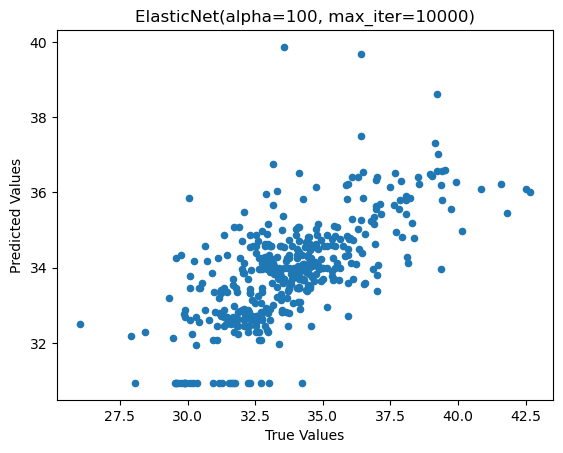

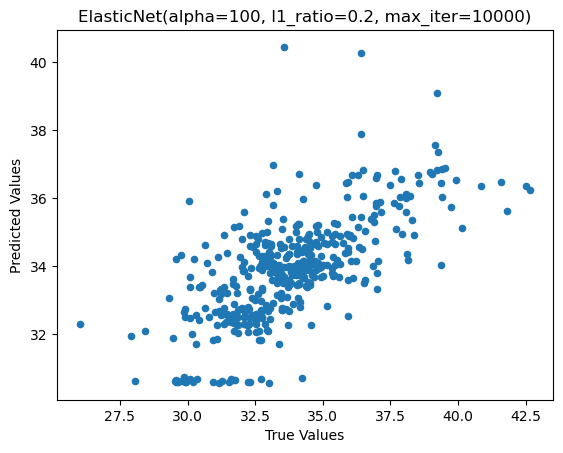

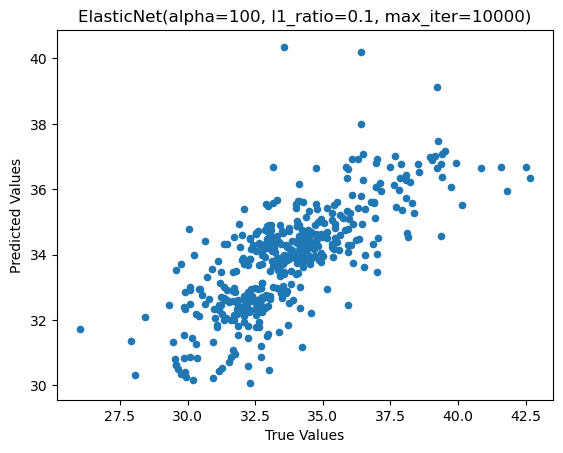

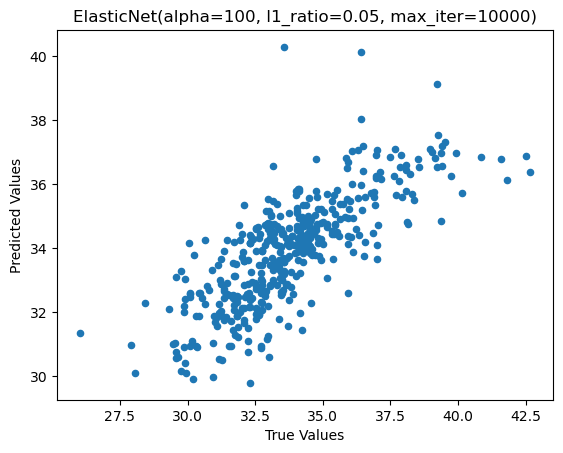

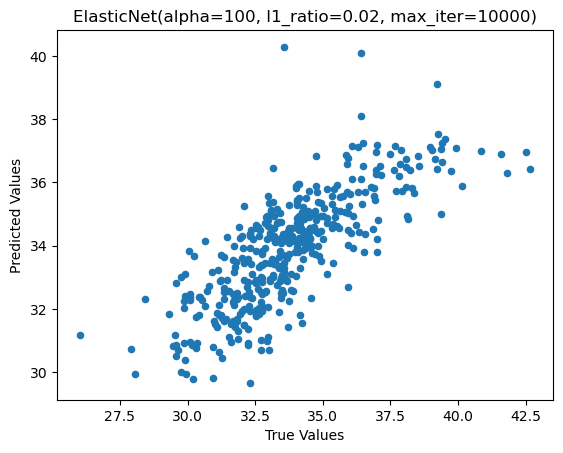

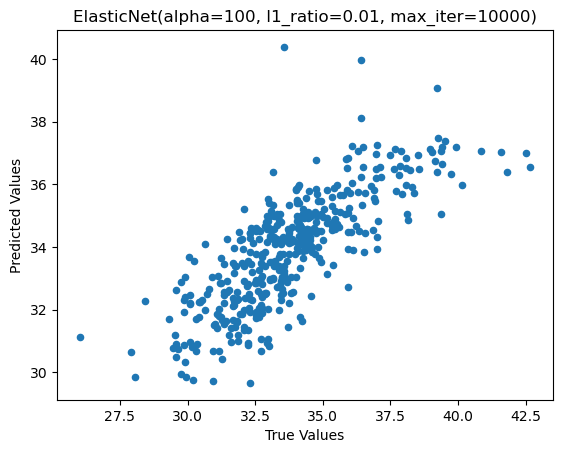

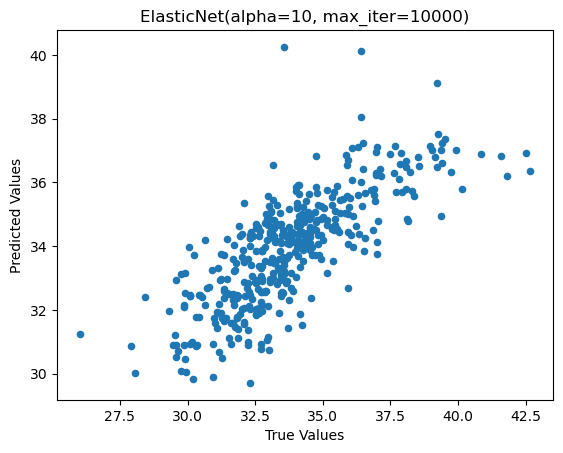

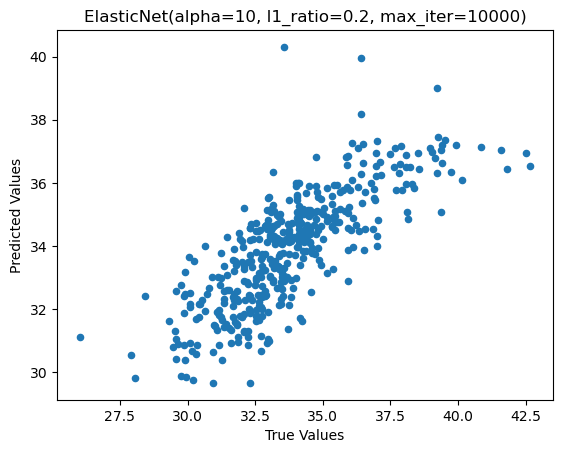

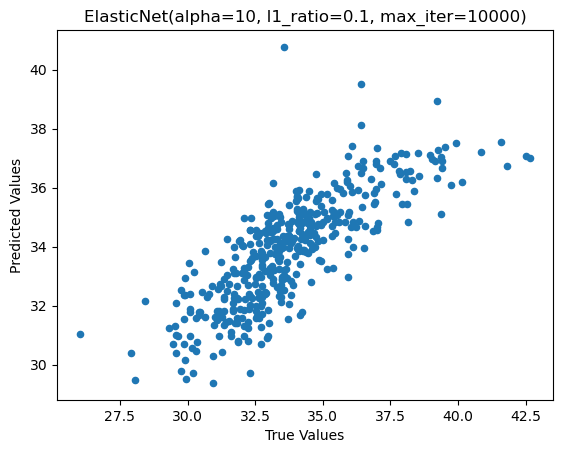

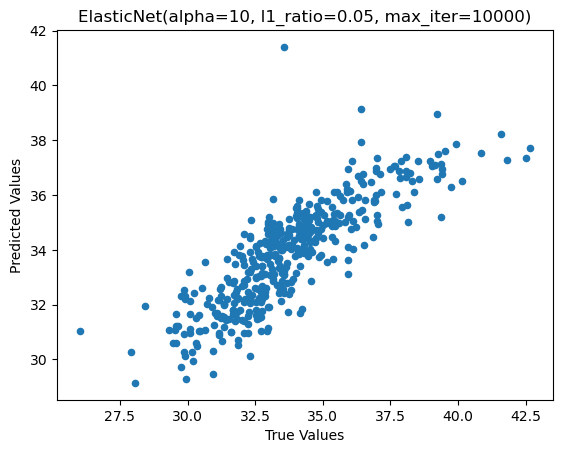

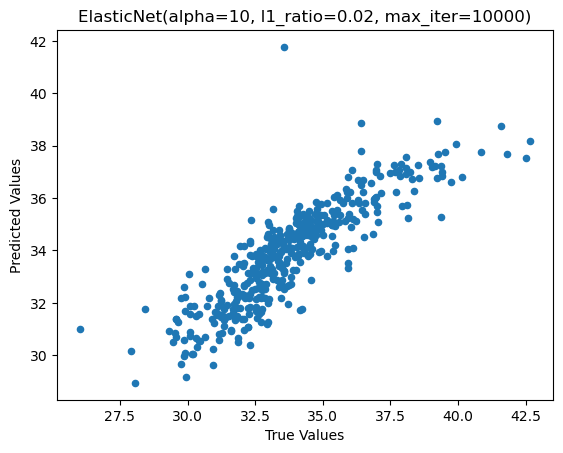

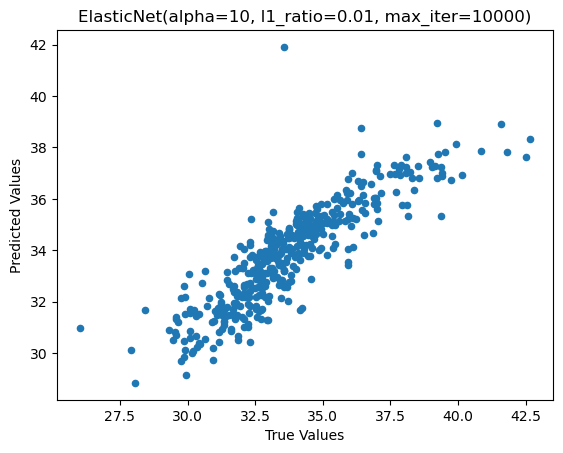

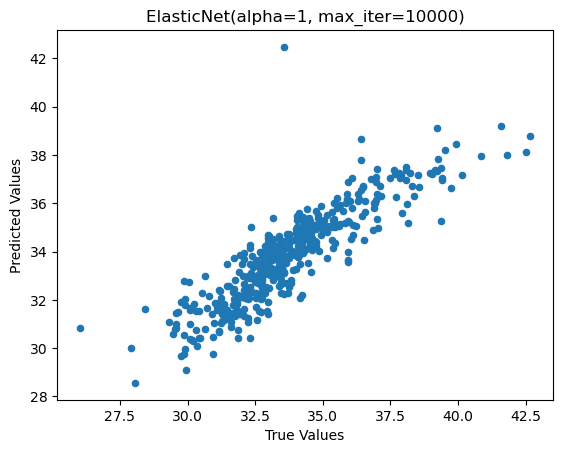

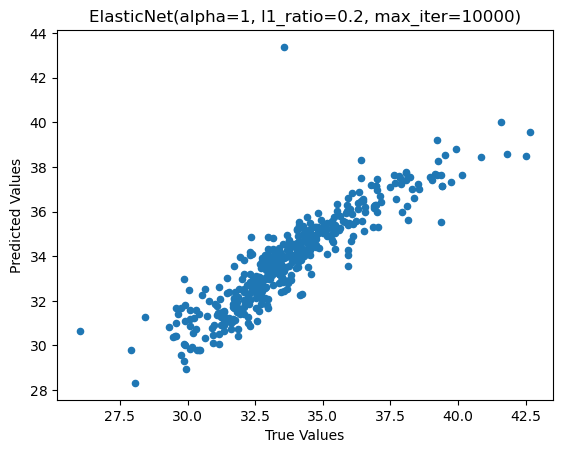

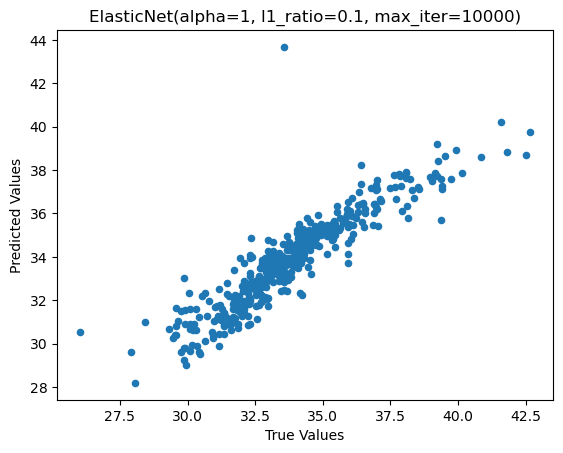

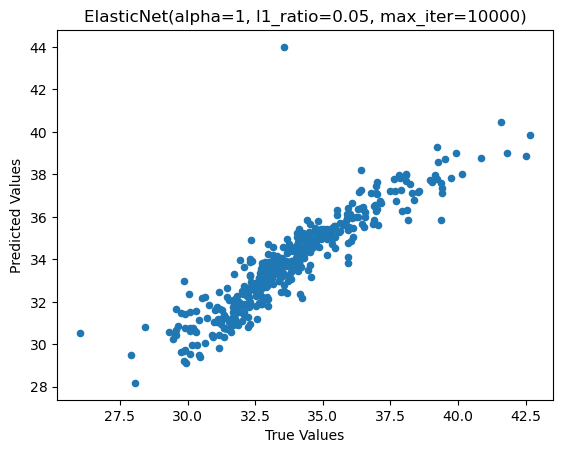

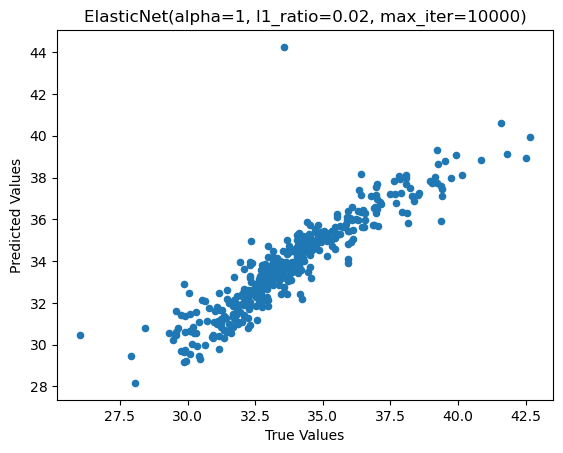

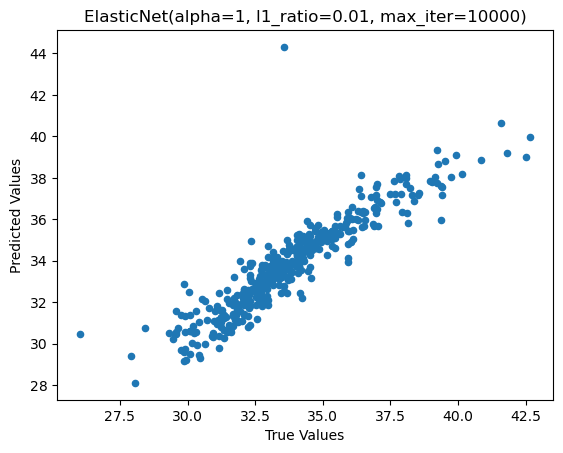

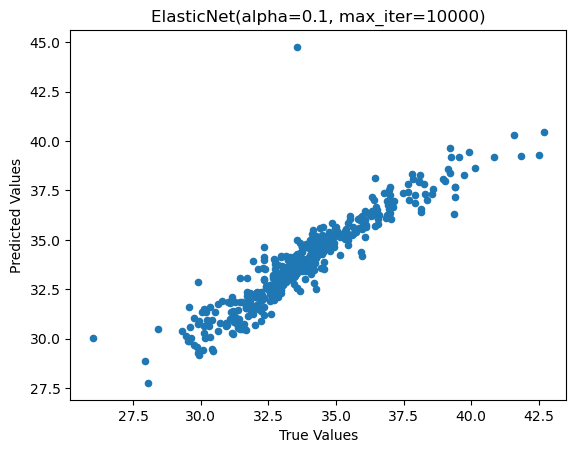

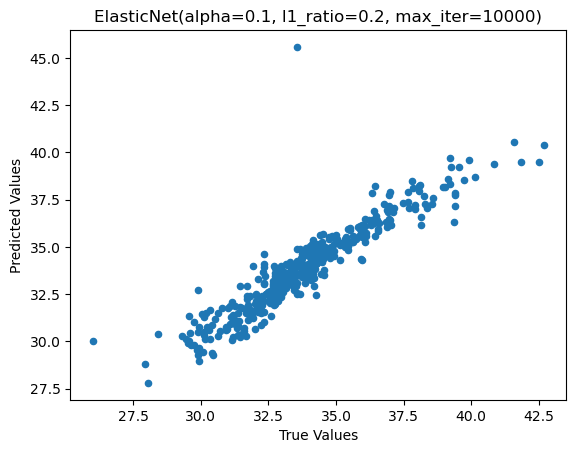

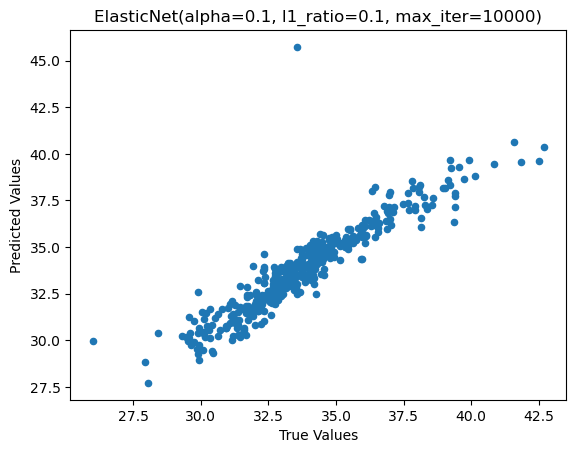

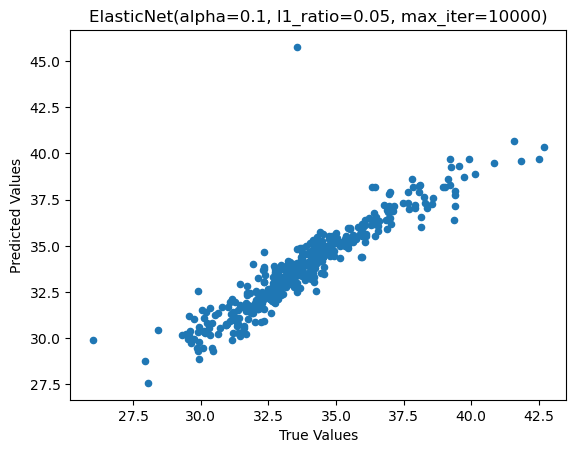

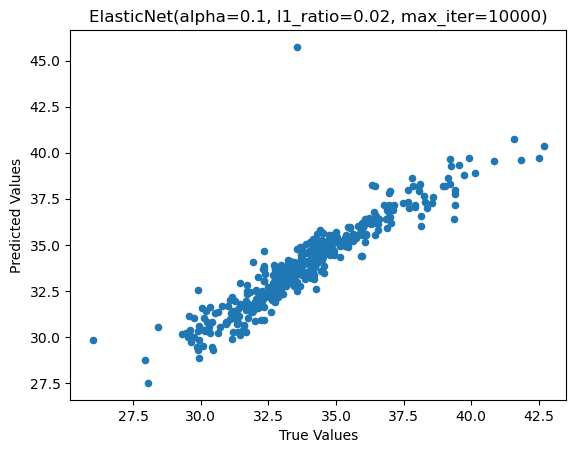

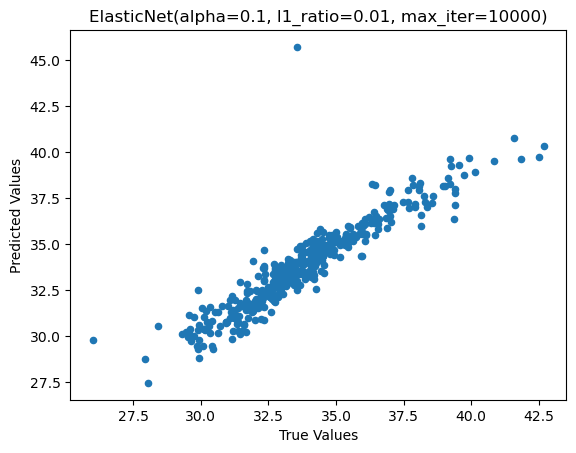

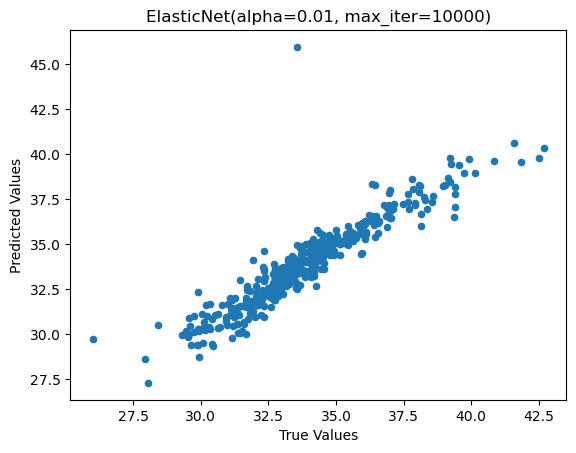

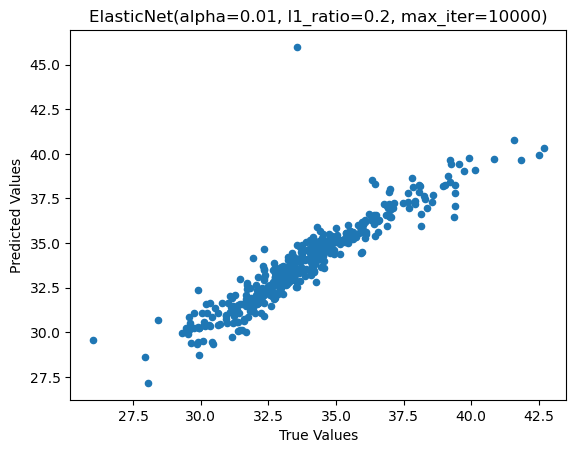

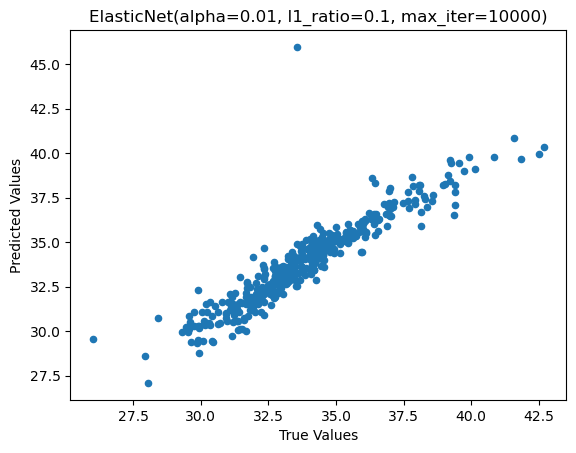

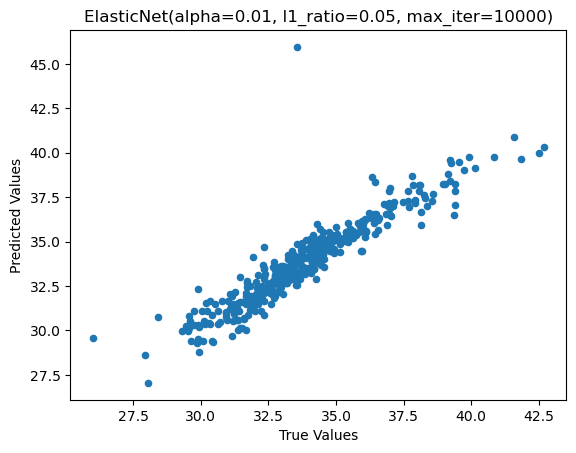

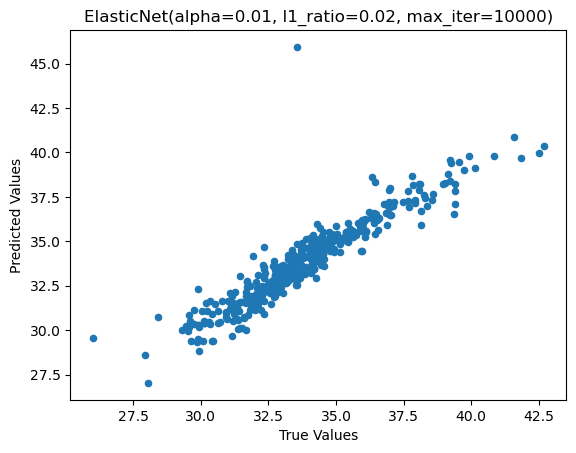

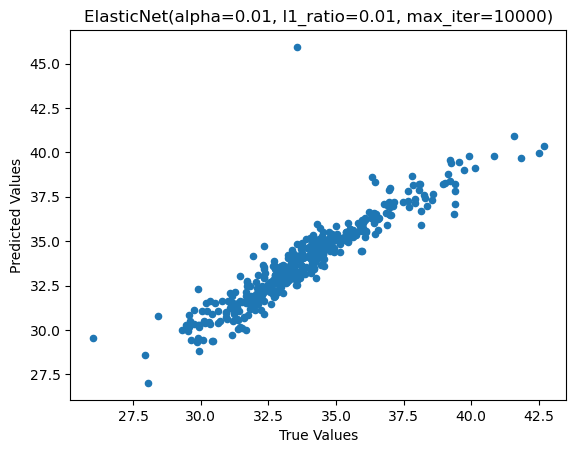

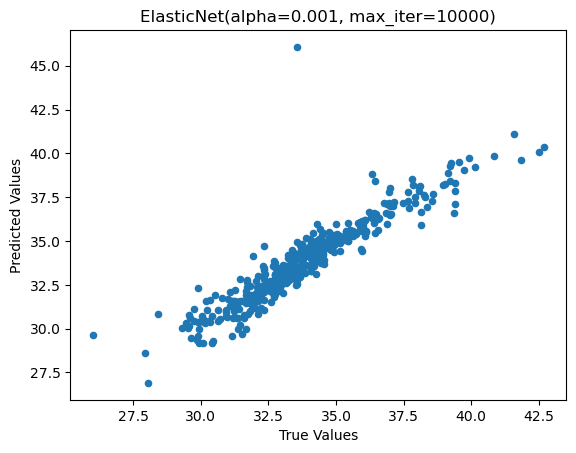

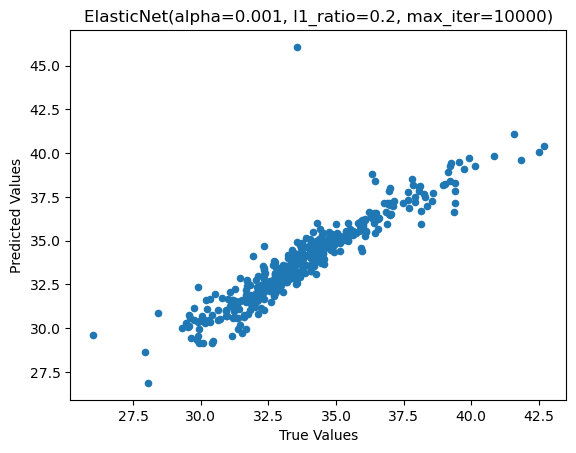

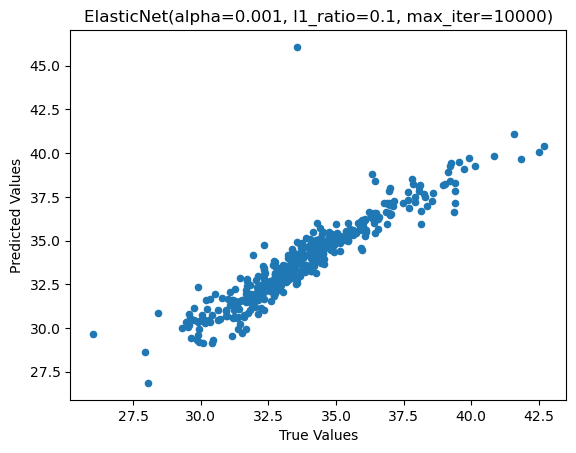

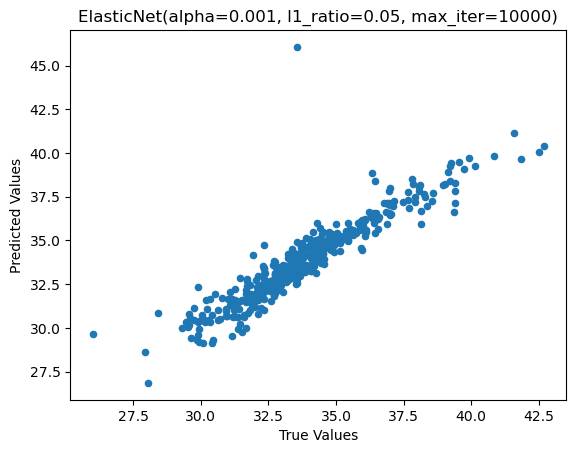

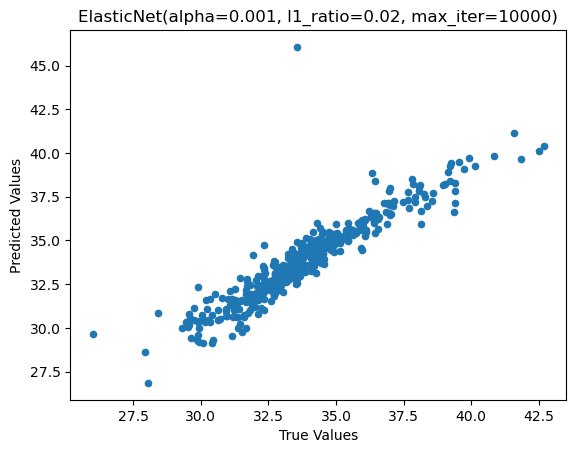

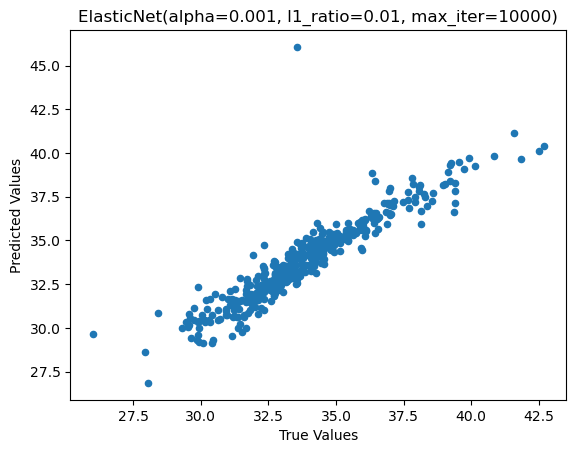

In [10]:
# Define features (X) and target variable (y)
X = df_simple.drop('SalePrice', axis=1)
y = df_simple['SalePrice']

alphas = [100, 10, 1, 0.1, 0.01, 0.001]
l1_ratios = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Initialize Elastic Net model
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)

        # Train Elastic Net model
        elastic_net, elastic_net_train_score, elastic_net_test_score = train_model(X, y, elastic_net)


## 4/ Explain the difference and meaning in the formulas of ridge, lasso and elastic net

### Ridge Regression

Ridge regression is a regularization technique that uses L2 regularization to add a penalty equivalent to the square of the magnitude of coefficients. This helps to prevent overfitting by discouraging large coefficients. The formula for Ridge regression is:

$$ \min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right\} $$

where:
- $y_i$ is the response variable
- $\beta_0$ is the intercept
- $\beta_j$ are the coefficients
- $x_{ij}$ are the predictors
- $\lambda$ is the tuning parameter controlling the strength of the penalty

### Lasso Regression

Lasso regression is another regularization technique that uses L1 regularization to add a penalty equivalent to the absolute value of the magnitude of coefficients. This can lead to some coefficients being shrunk to zero, effectively performing feature selection. The formula for Lasso regression is:

$$ \min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\} $$

where the symbols have the same meaning as in Ridge regression.

### Elastic Net Regression

Elastic Net regression is a hybrid of Ridge and Lasso regression. It uses both L1 and L2 regularization, which allows it to enjoy some of the feature selection benefits of Lasso while still retaining the regularization properties of Ridge. The formula for Elastic Net regression is:

$$ \min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j| + \lambda_2 \sum_{j=1}^{p} \beta_j^2 \right\} $$

where $\lambda_1$ and $\lambda_2$ are tuning parameters controlling the strength of the L1 and L2 penalties respectively.


## 5/ Apply sklearn's KNeighborsRegressor to house price data and compare performance with Linear Regression, Ridge, Lasso, Elastic Net models

Model: LinearRegression()
Training set score: 0.9118
Testing set score (test_size=0.3): 0.8465
Model: Ridge()
Training set score: 0.9116
Testing set score (test_size=0.3): 0.8477
Model: Lasso()
Training set score: 0.6406
Testing set score (test_size=0.3): 0.6505
Model: ElasticNet()
Training set score: 0.7707
Testing set score (test_size=0.3): 0.7611
Model: KNeighborsRegressor()
Training set score: 0.7466
Testing set score (test_size=0.3): 0.6500


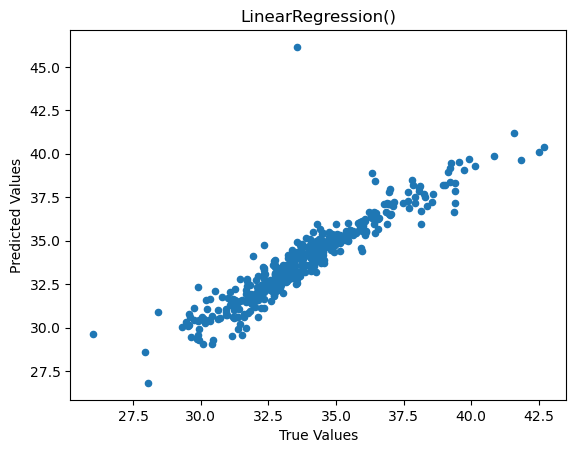

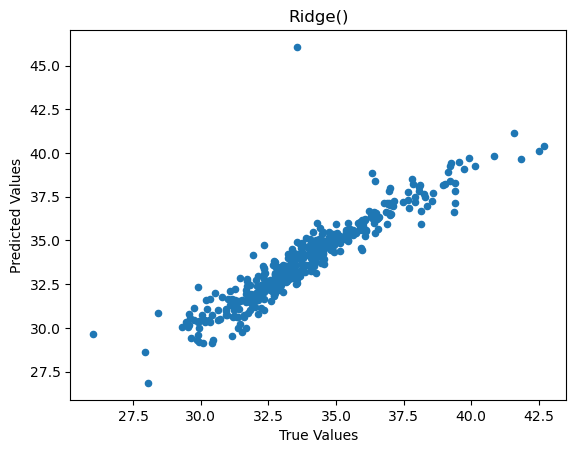

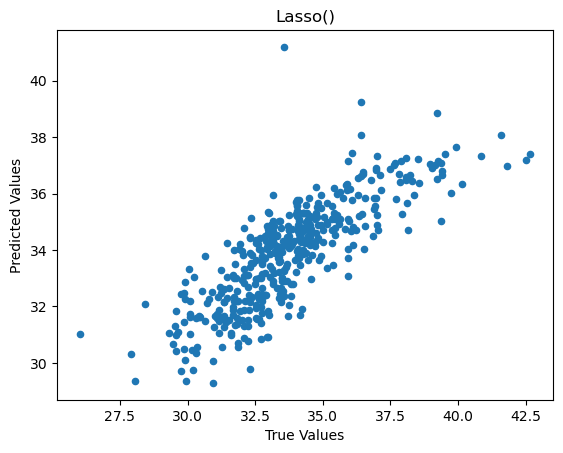

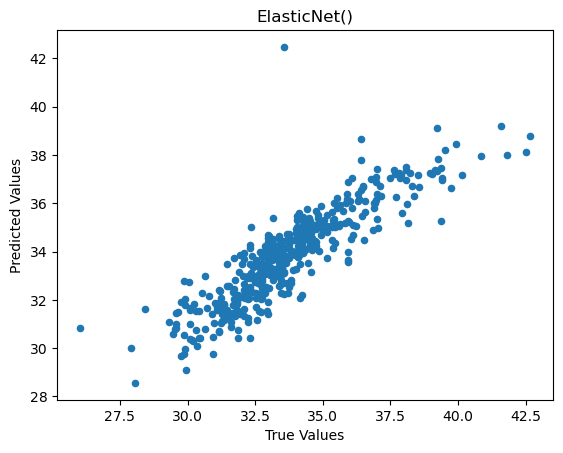

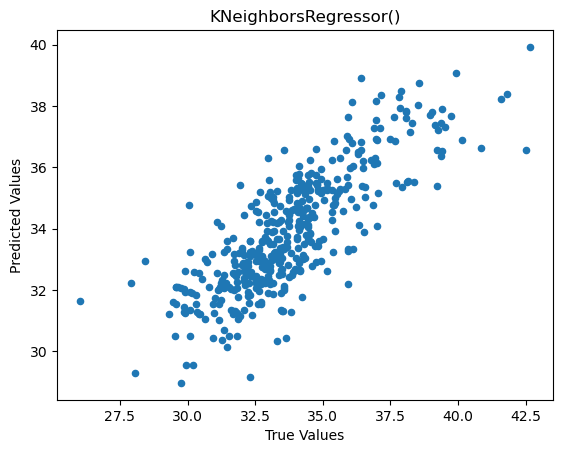

In [11]:
# Instantiate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate each model
for name, model in models.items():
    trained_model, train_score, test_score = train_model(X, y, model)
    # print(f'{name}: Train Score = {train_score:.2f}, Test Score = {test_score:.2f}, MSE = {mse:.2f}')

## 7/ Find out the meaning and change some metrics such as weights, algorithms, leafsize,... and the appropriate n_neighbors coefficient of the KNN model, compare performance

### KNeighborsRegressor Parameters
For the KNeighborsRegressor model, we can adjust the following parameters:
- n_neighbors: Number of neighbors to use for querying.
- weights: Weight function used in prediction (e.g., 'uniform', 'distance').
- algorithm: Algorithm used to compute the nearest neighbors.
- leaf_size: Leaf size passed to BallTree or KDTree.
- metric: The distance metric used to calculate the distance between points.
- n_jobs: The number of parallel jobs to run for neighbors search.

Model: KNeighborsRegressor()
Training set score: 0.7466
Testing set score (test_size=0.3): 0.6500
Model: KNeighborsRegressor(n_neighbors=3)
Training set score: 0.8037
Testing set score (test_size=0.3): 0.6427
Model: KNeighborsRegressor(n_neighbors=7)
Training set score: 0.7059
Testing set score (test_size=0.3): 0.6510
Model: KNeighborsRegressor(weights='distance')
Training set score: 1.0000
Testing set score (test_size=0.3): 0.6646
Model: KNeighborsRegressor(algorithm='ball_tree')
Training set score: 0.7466
Testing set score (test_size=0.3): 0.6500
Model: KNeighborsRegressor(algorithm='kd_tree')
Training set score: 0.7466
Testing set score (test_size=0.3): 0.6500
Model: KNeighborsRegressor(leaf_size=50)
Training set score: 0.7466
Testing set score (test_size=0.3): 0.6500


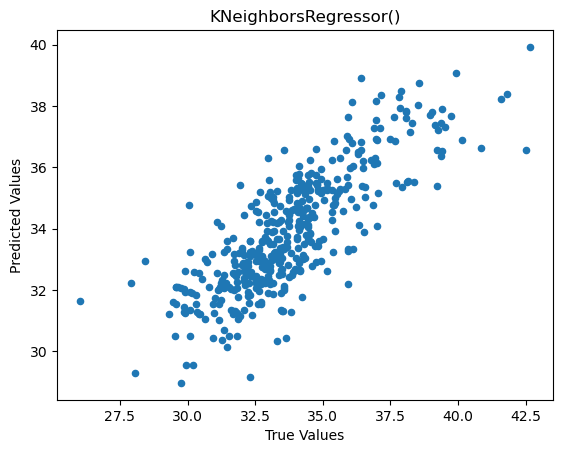

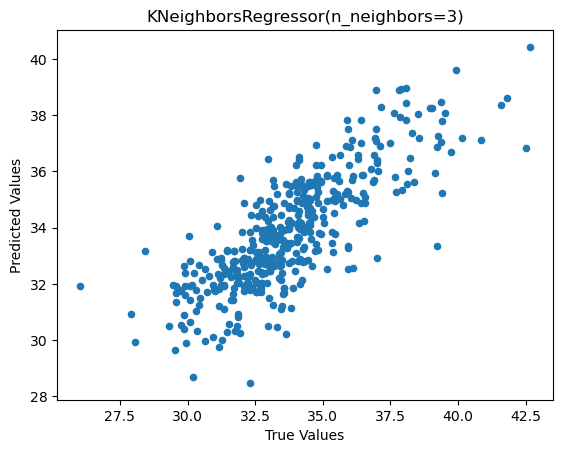

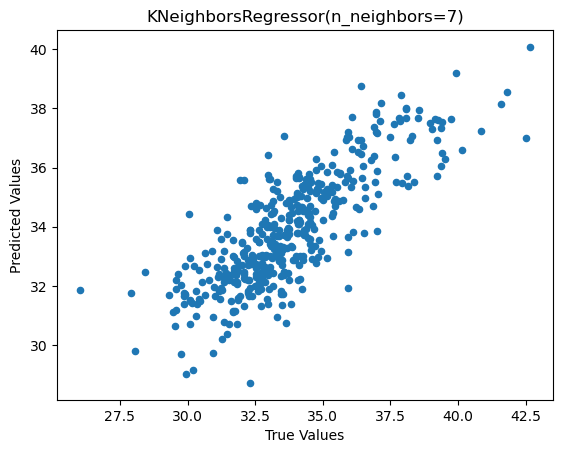

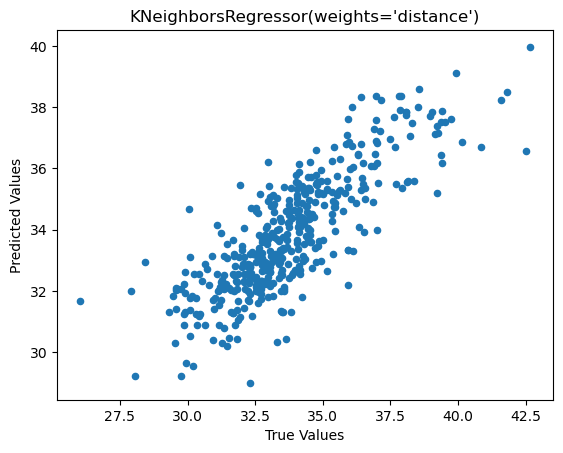

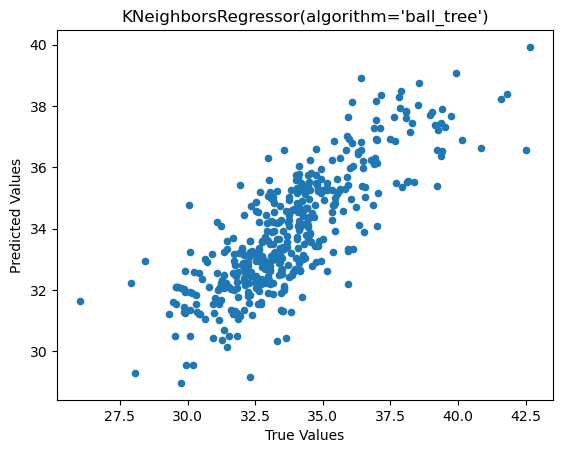

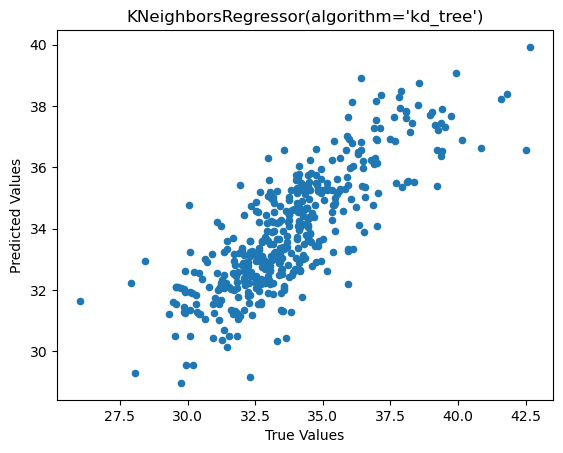

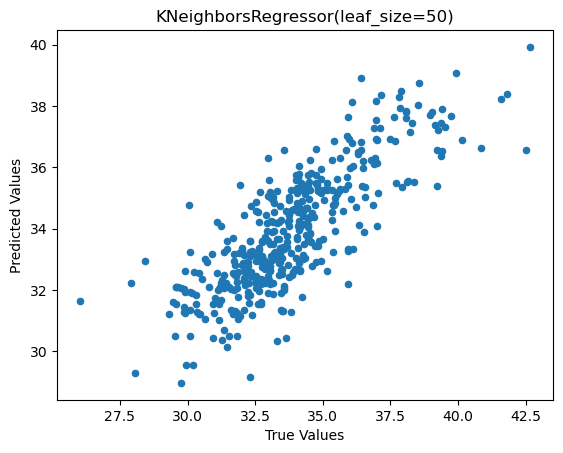

In [12]:
# Define parameters for KNeighborsRegressor
knn_params_list = [
    {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30}, # Default parameters
    {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30}, # Changed n_neighbors to 3
    {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30}, # Changed n_neighbors to 7
    {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 30}, # Changed weights to distance
    {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 30}, # Changed algorithm to ball_tree
    {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 30}, # Changed algorithm to kd_tree
    {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 50} # Changed leaf_size to 50
]

# Train and evaluate KNeighborsRegressor with different parameters
for idx, params in enumerate(knn_params_list):
    knn = KNeighborsRegressor(**params)
    knn, train_score, test_score = train_model(X, y, knn)
    # print(f'KNeighborsRegressor {idx + 1}: Train Score = {train_score:.2f}, Test Score = {test_score:.2f}, MSE = {mse:.2f}')

## 6/ Bank Marketing Exploratory Data Analysis (EDA)

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data/bank_marketing.csv')

# Display the first few rows of the dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [14]:
# Display the summary statistics of the numerical columns
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


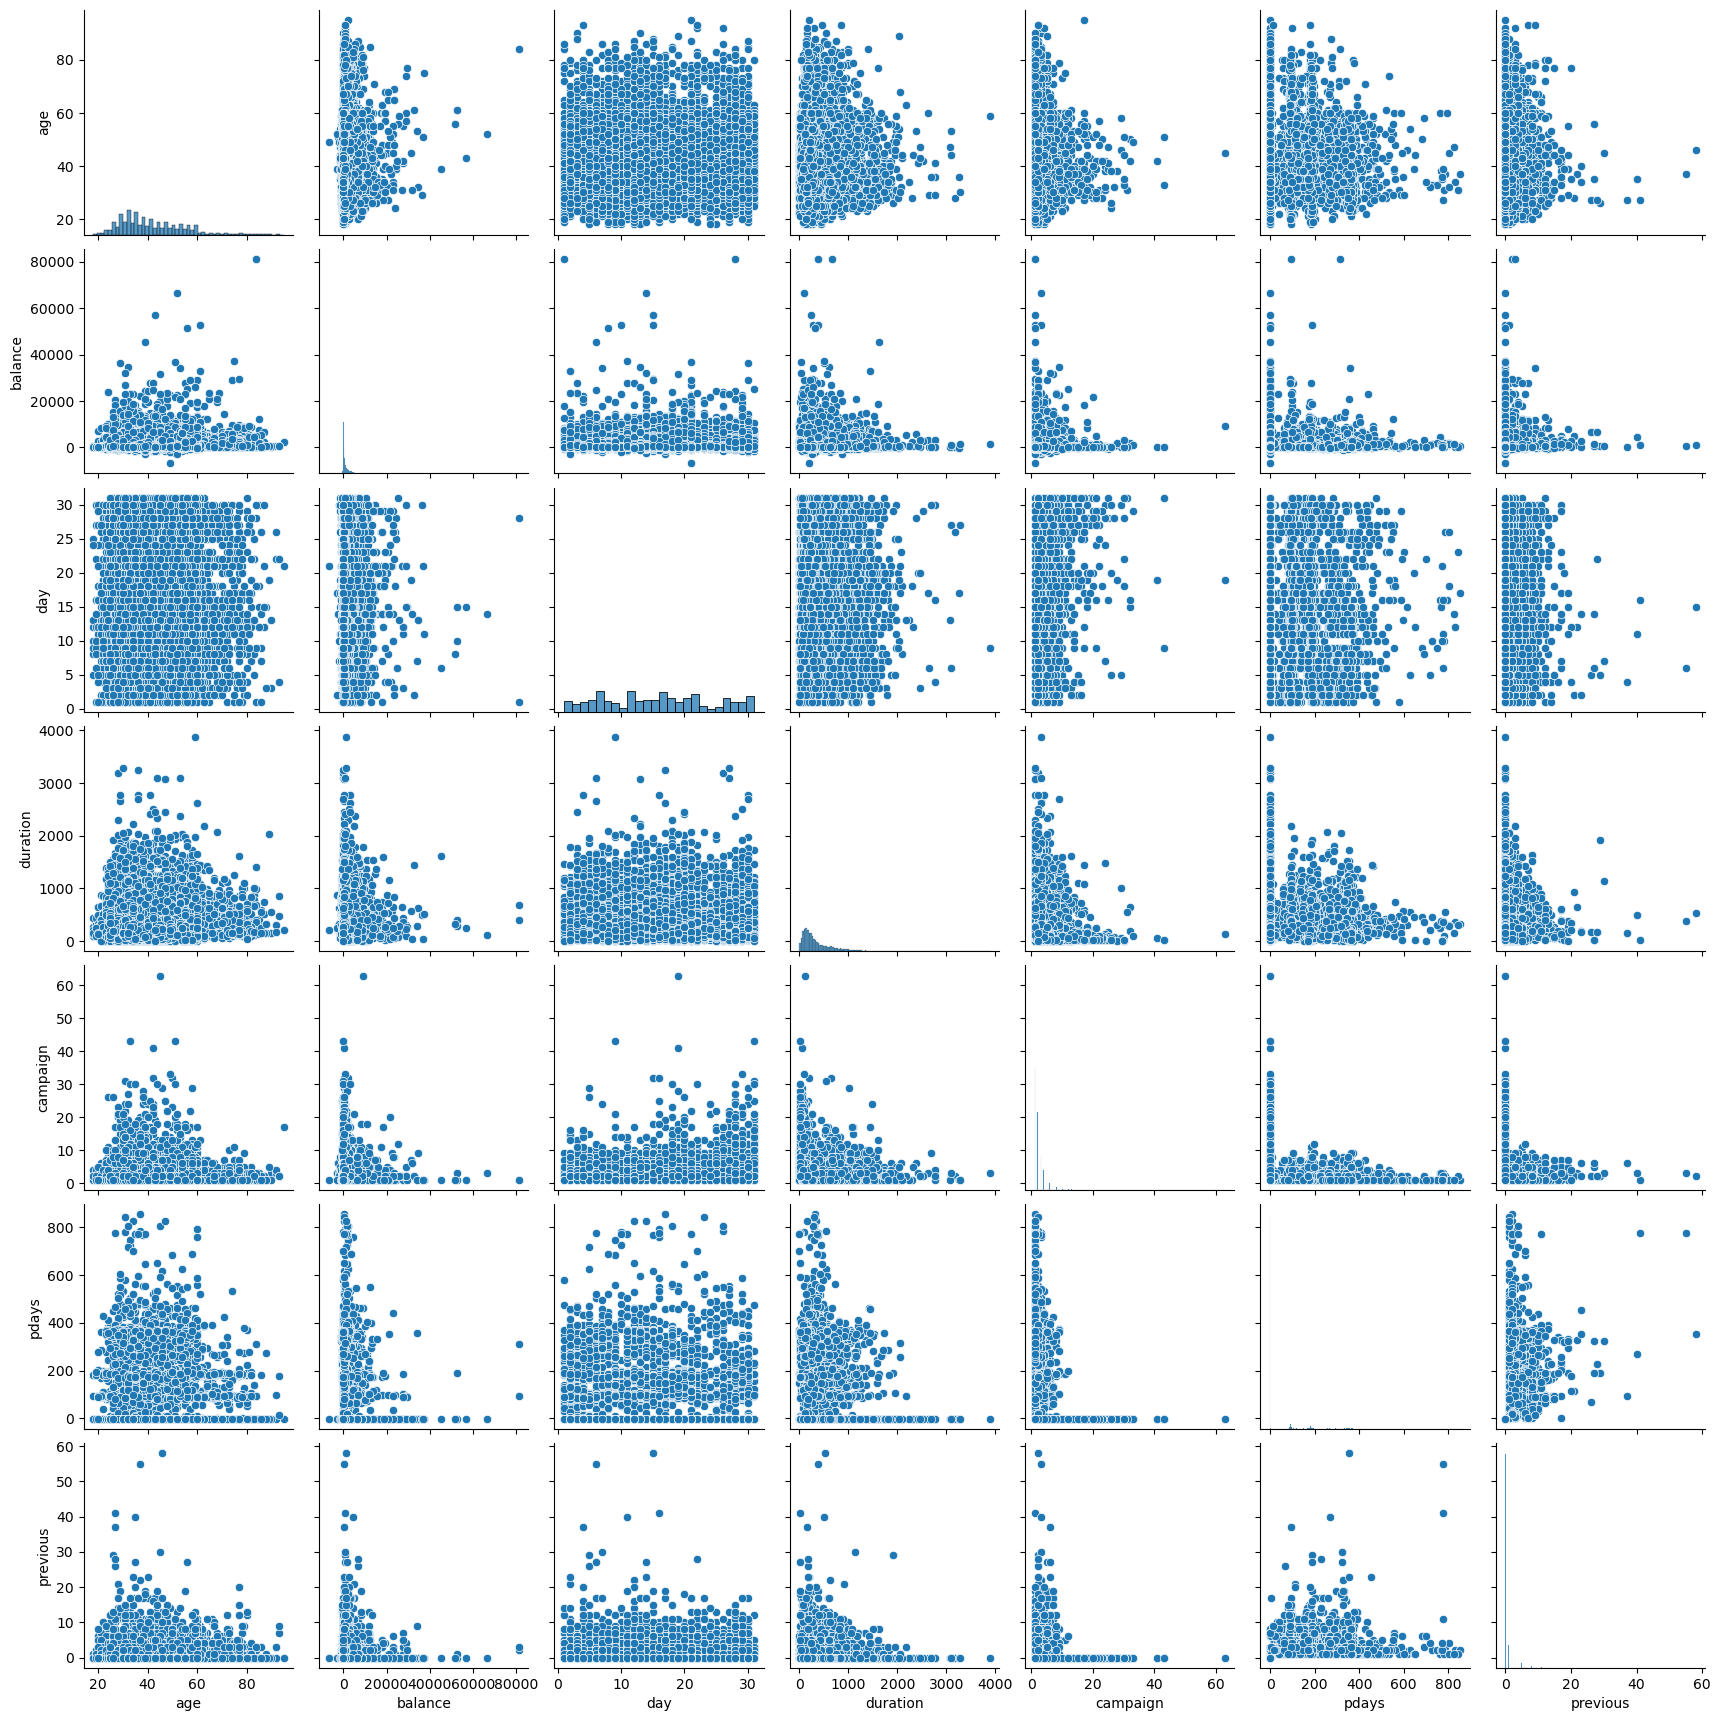

In [15]:
# Generate a pairplot of the dataset
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.show()

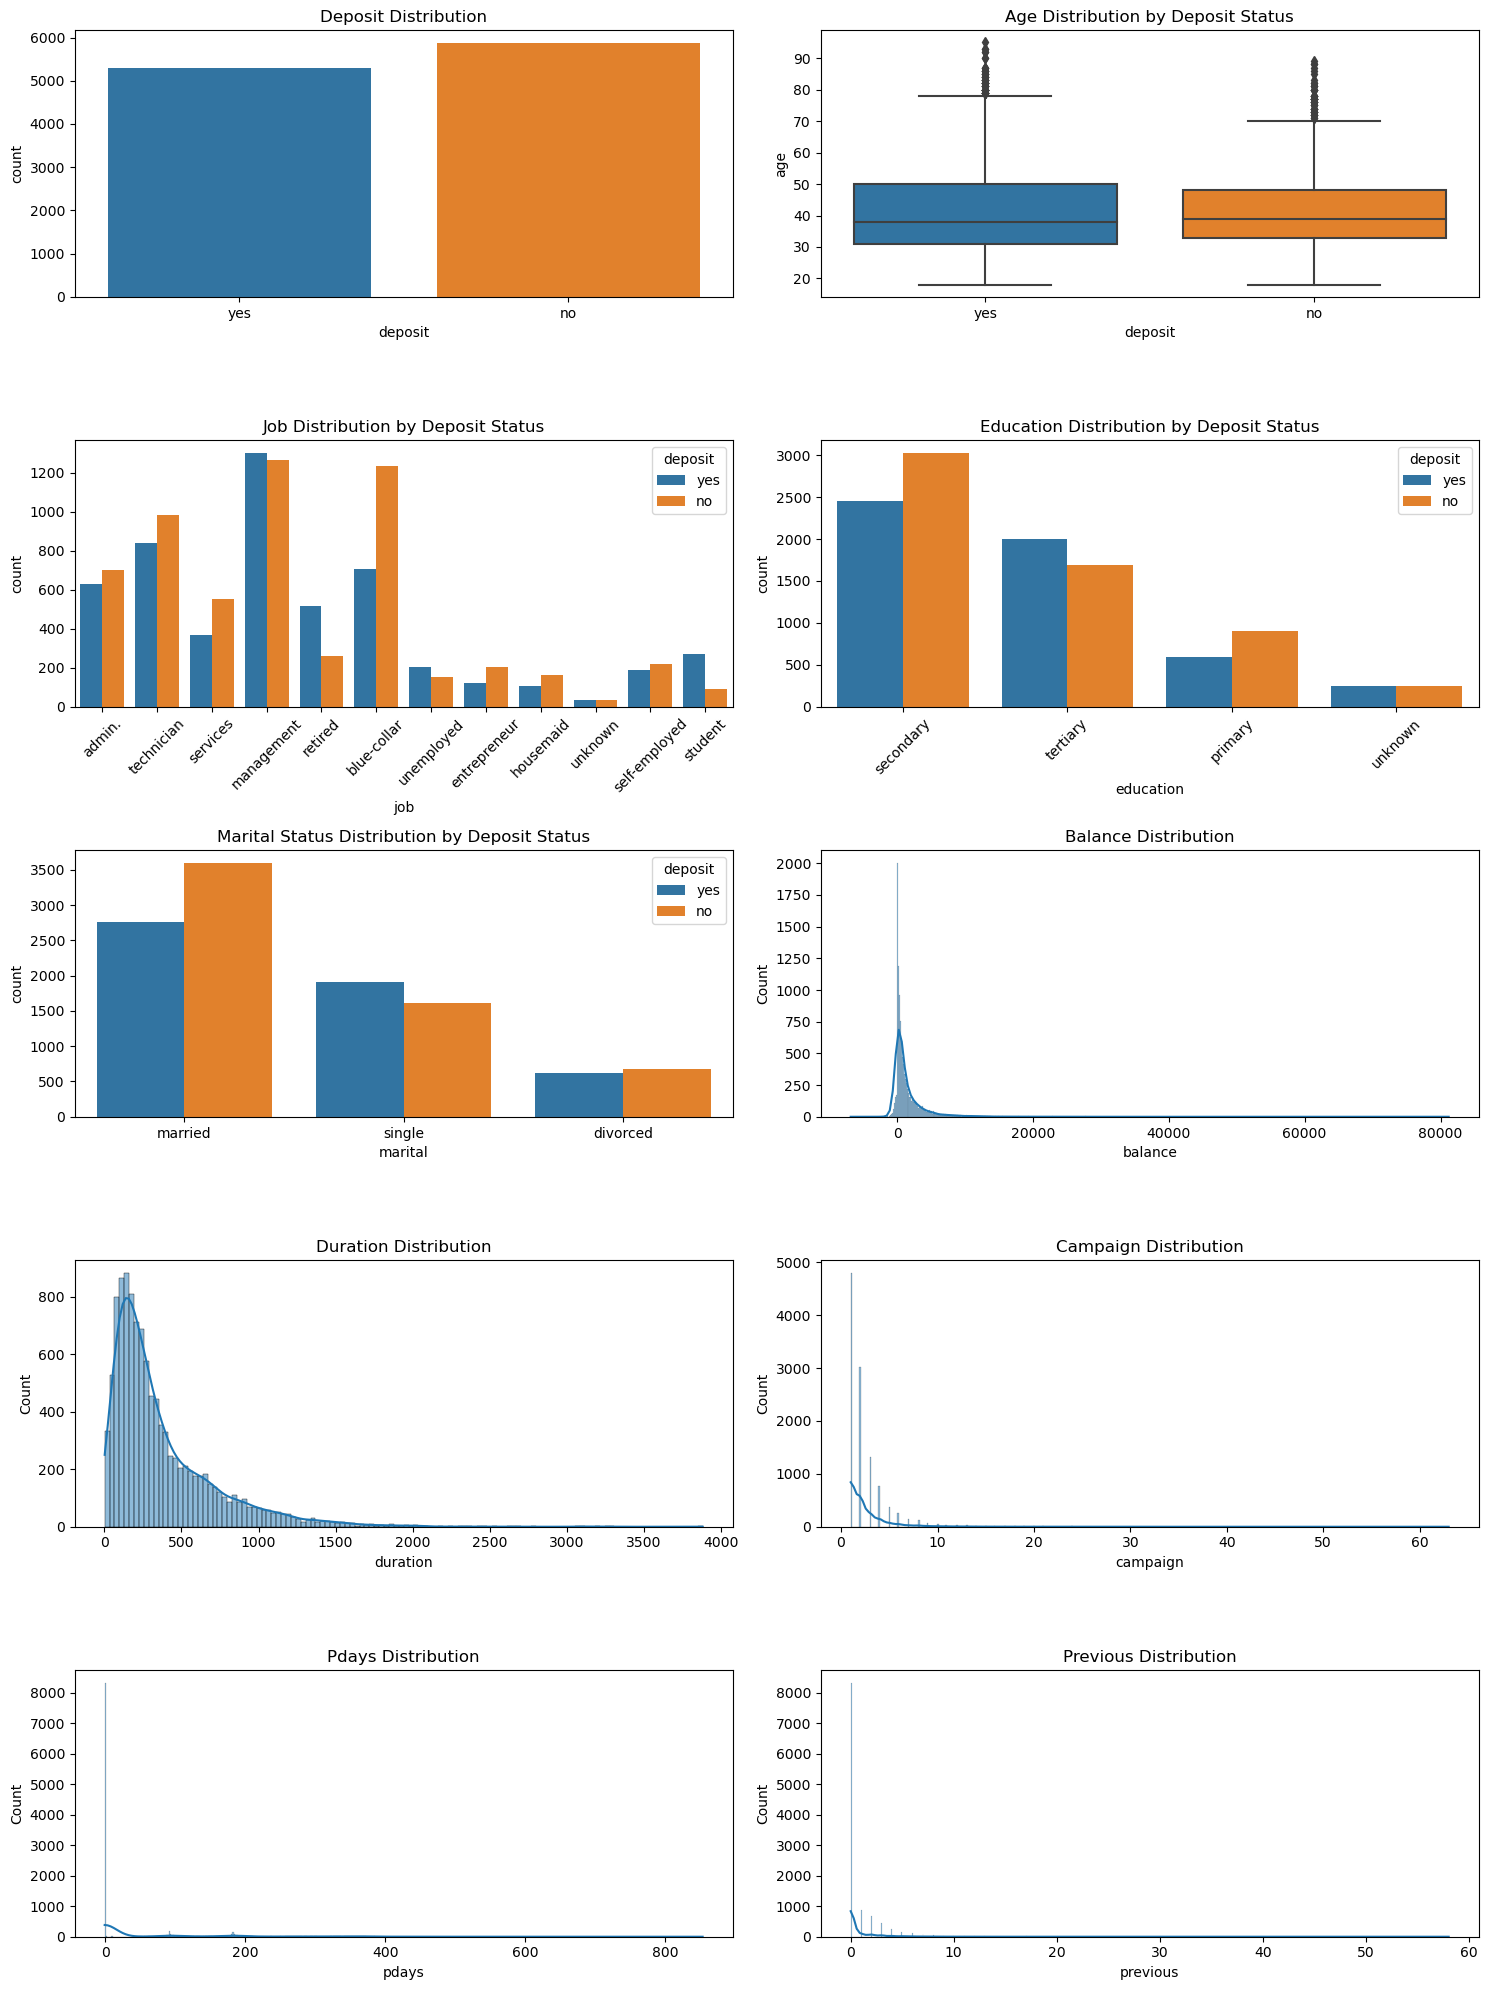

In [16]:
# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Display the distribution of the 'deposit' column
sns.countplot(x='deposit', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Deposit Distribution')

# Display the age distribution by deposit status
sns.boxplot(x='deposit', y='age', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Deposit Status')

# Display the job distribution by deposit status
sns.countplot(x='job', hue='deposit', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Job Distribution by Deposit Status')
axes[1, 0].tick_params(axis='x', rotation=45)

# Display the education distribution by deposit status
sns.countplot(x='education', hue='deposit', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Education Distribution by Deposit Status')
axes[1, 1].tick_params(axis='x', rotation=45)

# Display the marital status distribution by deposit status
sns.countplot(x='marital', hue='deposit', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Marital Status Distribution by Deposit Status')

# Display the distribution of the 'balance' column
sns.histplot(df['balance'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Balance Distribution')

# Display the distribution of the 'duration' column
sns.histplot(df['duration'], kde=True, ax=axes[3, 0])
axes[3, 0].set_title('Duration Distribution')

# Display the distribution of the 'campaign' column
sns.histplot(df['campaign'], kde=True, ax=axes[3, 1])
axes[3, 1].set_title('Campaign Distribution')

# Display the distribution of the 'pdays' column
sns.histplot(df['pdays'], kde=True, ax=axes[4, 0])
axes[4, 0].set_title('Pdays Distribution')

# Display the distribution of the 'previous' column
sns.histplot(df['previous'], kde=True, ax=axes[4, 1])
axes[4, 1].set_title('Previous Distribution')

# Adjust layout
plt.tight_layout()
plt.show()